In [1]:
import sys
!{sys.executable} -m pip install plotly torch huggingface_hub sae_lens transformer_lens sae_dashboard plotly "ipywidgets>=7.5"

In [2]:
try:
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    # %pip install sae-lens transformer-lens sae-dashboard
except:
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
from tqdm import tqdm
import plotly.express as px
import pandas as pd

# Imports for displaying vis in Colab / notebook

torch.set_grad_enabled(False)

# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [3]:
from huggingface_hub import notebook_login
notebook_login()


In [7]:
from sae_lens import SAE, HookedSAETransformer

model = HookedSAETransformer.from_pretrained("gemma-2-2b", device=device)


# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
torch.cuda.empty_cache()
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res", # see other options in sae_lens/pretrained_saes.yaml
    sae_id = "layer_20/width_16k/average_l0_71", # won't always be a hook point
    # sae_id = "layer_25/width_16k/average_l0_116", # won't always be a hook point
    device = device
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [59]:
saes_and_features = [(5, "average_l0_68", {"bridge" : 3839, "sf": 1385}), 
 (10, "average_l0_77", {"bridge" : 6050, "sf": 2196}),
 (16, "average_l0_78", {"bridge" : 1459, "sf": None}),
 (20, "average_l0_71", {"bridge" : 6492, "sf": 3124}),
 (24, "average_l0_73", {"bridge" : 1402, "sf": 4187}),
 (25, "average_l0_116", {"bridge" : 16057, "sf": 4233})]

In [8]:
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path = "NeelNanda/pile-10k",
    split="train",
    streaming=False,
)


token_dataset = tokenize_and_concatenate(
    dataset= dataset,# type: ignore
    tokenizer = model.tokenizer, # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)

(15185, 1)
torch.Size([3, 1024])
average l0 89.1495590209961


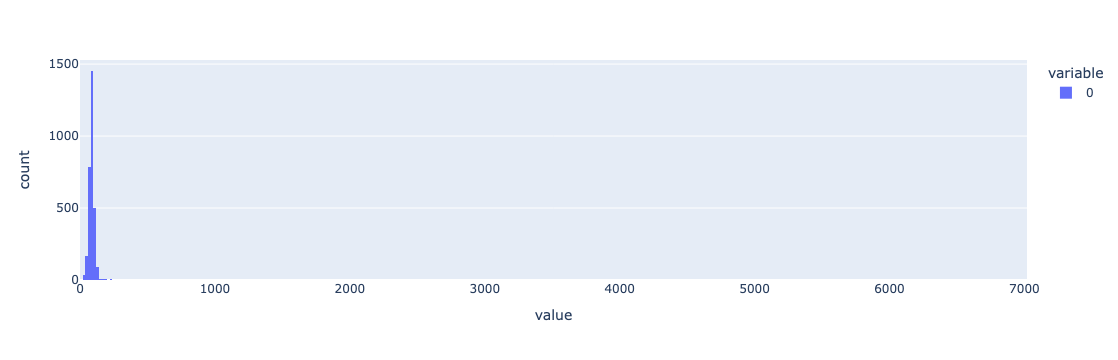

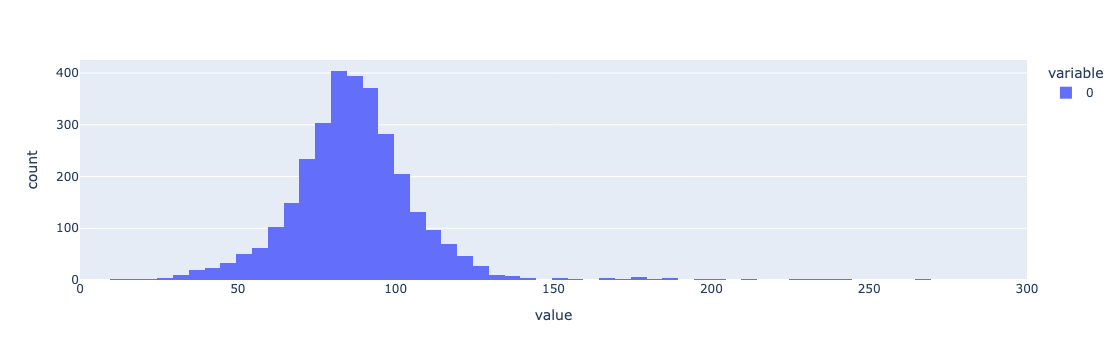

In [13]:
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads
print(token_dataset.shape)
with torch.no_grad():
    # activation store can give us tokens.
    batch_tokens = token_dataset[:3]["tokens"]
    print(batch_tokens.shape)
    _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

    # Use the SAE
    feature_acts = sae.encode(cache[sae.cfg.hook_name])
    sae_out = sae.decode(feature_acts)

    # save some room
    del cache

    # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
    l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
    print("average l0", l0.mean().item())
    px.histogram(l0.flatten().cpu().numpy()).show()
    
    fig = px.histogram(l0.flatten().cpu().numpy(), nbins=3000)
    fig.update_xaxes(range=[0, 300])
    fig.show()


In [14]:
from transformer_lens import utils
from functools import partial

example_prompt = "When John and Mary went to the shops, John gave the bag to"
example_answer = " Mary"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

logits, cache = model.run_with_cache(example_prompt, prepend_bos=True)
tokens = model.to_tokens(example_prompt)
sae_out = sae(cache[sae.cfg.hook_name])


def reconstr_hook(activations, hook, sae_out):
    return sae_out


def zero_abl_hook(mlp_out, hook):
    return torch.zeros_like(mlp_out)


hook_name = sae.cfg.hook_name

print("Orig", model(tokens, return_type="loss").item())
print(
    "reconstr",
    model.run_with_hooks(
        tokens,
        fwd_hooks=[
            (
                hook_name,
                partial(reconstr_hook, sae_out=sae_out),
            )
        ],
        return_type="loss",
    ).item(),
)
print(
    "Zero",
    model.run_with_hooks(
        tokens,
        return_type="loss",
        fwd_hooks=[(hook_name, zero_abl_hook)],
    ).item(),
)


with model.hooks(
    fwd_hooks=[
        (
            hook_name,
            partial(reconstr_hook, sae_out=sae_out),
        )
    ]
):
    utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<bos>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 28.06 Prob: 67.14% Token: | Mary|

Top 0th token. Logit: 28.06 Prob: 67.14% Token: | Mary|
Top 1th token. Logit: 26.70 Prob: 17.18% Token: | the|
Top 2th token. Logit: 25.47 Prob:  5.02% Token: | his|
Top 3th token. Logit: 24.47 Prob:  1.85% Token: | a|
Top 4th token. Logit: 24.20 Prob:  1.41% Token: | John|
Top 5th token. Logit: 22.98 Prob:  0.42% Token: | Mrs|
Top 6th token. Logit: 22.70 Prob:  0.31% Token: | her|
Top 7th token. Logit: 22.61 Prob:  0.29% Token: | mary|
Top 8th token. Logit: 22.59 Prob:  0.28% Token: | their|
Top 9th token. Logit: 22.56 Prob:  0.27% Token: | Maria|


Ranks of the answer tokens: [(' Mary', 0)]

Orig 3.3202977180480957
reconstr 4.49444055557251
Zero 12.452932357788086
Tokenized prompt: ['<bos>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 28.16 Prob: 33.37% Token: | Mary|

Top 0th token. Logit: 28.16 Prob: 33.37% Token: | Mary|
Top 1th token. Logit: 28.07 Prob: 30.26% Token: | the|
Top 2th token. Logit: 27.39 Prob: 15.38% Token: | John|
Top 3th token. Logit: 26.60 Prob:  6.98% Token: | his|
Top 4th token. Logit: 25.86 Prob:  3.33% Token: | a|
Top 5th token. Logit: 24.87 Prob:  1.24% Token: | her|
Top 6th token. Logit: 24.43 Prob:  0.80% Token: | him|
Top 7th token. Logit: 24.01 Prob:  0.52% Token: |
|
Top 8th token. Logit: 23.81 Prob:  0.43% Token: | Mrs|
Top 9th token. Logit: 23.77 Prob:  0.41% Token: | an|


Ranks of the answer tokens: [(' Mary', 0)]

In [15]:
# instantiate an object to hold activations from a dataset
from sae_lens import ActivationsStore

# a convenient way to instantiate an activation store is to use the from_sae method
activation_store = ActivationsStore.from_sae(
    model=model,
    sae=sae,
    streaming=True,
    # fairly conservative parameters here so can use same for larger
    # models without running out of memory.
    store_batch_size_prompts=8,
    train_batch_size_tokens=4096,
    n_batches_in_buffer=32,
    device=device,
)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [18]:
def list_flatten(nested_list):
    return [x for y in nested_list for x in y]

# A very handy function Neel wrote to get context around a feature activation
def make_token_df(tokens, len_prefix=5, len_suffix=3, model = model):
    str_tokens = [model.to_str_tokens(t) for t in tokens]
    unique_token = [[f"{s}/{i}" for i, s in enumerate(str_tok)] for str_tok in str_tokens]
    
    context = []
    prompt = []
    pos = []
    label = []
    for b in range(tokens.shape[0]):
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            if p==tokens.shape[1]-1:
                suffix = ""
            else:
                suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            prompt.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
    # print(len(batch), len(pos), len(context), len(label))
    return pd.DataFrame(dict(
        str_tokens=list_flatten(str_tokens),
        unique_token=list_flatten(unique_token),
        context=context,
        prompt=prompt,
        pos=pos,
        label=label,
    ))

In [19]:

# finding max activating examples is a bit harder. To do this we need to calculate feature activations for a large number of tokens
feature_list = torch.randint(0, sae.cfg.d_sae, (100,))
examples_found = 0
all_fired_tokens = []
all_feature_acts = []
all_reconstructions = []
all_token_dfs = []

total_batches = 100
batch_size_prompts = activation_store.store_batch_size_prompts
batch_size_tokens = activation_store.context_size * batch_size_prompts
pbar = tqdm(range(total_batches))
for i in pbar:
    tokens = activation_store.get_batch_tokens()
    tokens_df = make_token_df(tokens)
    tokens_df["batch"] = i
    
    flat_tokens = tokens.flatten()
    
    _, cache = model.run_with_cache(tokens, stop_at_layer = sae.cfg.hook_layer + 1, names_filter = [sae.cfg.hook_name])
    sae_in = cache[sae.cfg.hook_name]
    feature_acts = sae.encode(sae_in).squeeze()

    feature_acts = feature_acts.flatten(0,1)
    fired_mask = (feature_acts[:, feature_list]).sum(dim=-1) > 0
    fired_tokens = model.to_str_tokens(flat_tokens[fired_mask])
    reconstruction = feature_acts[fired_mask][:, feature_list] @ sae.W_dec[feature_list]

    token_df = tokens_df.iloc[fired_mask.cpu().nonzero().flatten().numpy()]
    all_token_dfs.append(token_df)
    all_feature_acts.append(feature_acts[fired_mask][:, feature_list])
    all_fired_tokens.append(fired_tokens)
    all_reconstructions.append(reconstruction)
    
    examples_found += len(fired_tokens)
    # print(f"Examples found: {examples_found}")
    # update description
    pbar.set_description(f"Examples found: {examples_found}")
    
# flatten the list of lists
all_token_dfs = pd.concat(all_token_dfs)
all_fired_tokens = list_flatten(all_fired_tokens)
all_reconstructions = torch.cat(all_reconstructions)
all_feature_acts = torch.cat(all_feature_acts)

Examples found: 236567: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


In [21]:
feature_acts_df = pd.DataFrame(all_feature_acts.detach().cpu().numpy(), columns = [f"feature_{i}" for i in feature_list])
feature_acts_df.shape

(236567, 100)

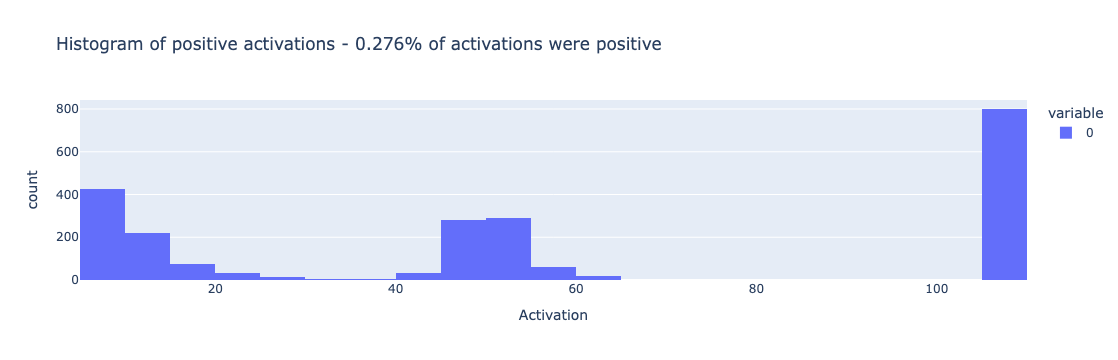

In [22]:
feature_idx = 0
# get non-zero activations

all_positive_acts = all_feature_acts[all_feature_acts[:, feature_idx] > 0][:, feature_idx].detach()
prop_positive_activations = 100*len(all_positive_acts) / (total_batches*batch_size_tokens)

px.histogram(
    all_positive_acts.cpu(),
    nbins=50,
    title=f"Histogram of positive activations - {prop_positive_activations:.3f}% of activations were positive",
    labels={"value": "Activation"},
    width=800,)

In [24]:
print(f"Shape of the decoder weights {sae.W_dec.shape})")
print(f"Shape of the model unembed {model.W_U.shape}")
projection_matrix = sae.W_dec @ model.W_U
print(f"Shape of the projection matrix {projection_matrix.shape}")

# then we take the top_k tokens per feature and decode them
top_k = 10
# let's do this for 100 random features
_, top_k_tokens = torch.topk(projection_matrix[feature_list], top_k, dim=1)


feature_df = pd.DataFrame(top_k_tokens.cpu().numpy(), index = [f"feature_{i}" for i in feature_list]).T
feature_df.index = [f"token_{i}" for i in range(top_k)]
feature_df.applymap(lambda x: model.tokenizer.decode(x))

Shape of the decoder weights torch.Size([16384, 2304]))
Shape of the model unembed torch.Size([2304, 256000])
Shape of the projection matrix torch.Size([16384, 256000])


/tmp/ipykernel_77/4260783916.py:14: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,feature_6397,feature_2657,feature_4502,feature_724,feature_10174,feature_851,feature_4522,feature_4504,feature_14324,feature_15701,...,feature_15367,feature_12906,feature_8251,feature_956,feature_2612,feature_8013,feature_13541,feature_2166,feature_4097,feature_15652
token_0,DockStyle,$,series,map,IMPORTED,shell,PhysRev,diagram,iness,vector,...,signaling,ww,panic,season,campaigns,resourceCulture,answer,statistics,static,also
token_1,SwitchCompat,"<>"",",Pro,maps,gatron,Shell,Reviews,diagrams,IUrlHelper,vector,...,phosphorylation,wwww,Go,season,themſelves,ModelExpression,answer,stats,للمعارف,-
token_2,Personendaten,الحره,models,Map,e,shells,Reviews,Diagram,riwal,cout,...,kinases,wwwwwwww,go,Season,Campaigns,AFP,Explanation,Statistics,class,most
token_3,GIP,ISNI,Series,Map,Redacción,Shell,REVIEWS,flowchart,pollution,ios,...,pathways,wwwww,panic,Season,campaign,aarrggbb,Explanation,statistic,rowspan,Bardzo
token_4,فريبيس,✭,pro,Maps,Saludos,shell,reviews,diagram,logrus,string,...,kinase,WWWW,package,seasons,slogans,Vainqueur,Answer,statistics,IVEREF,","
token_5,PerformLayout,propOrder,Mk,map,ябре,SHELL,Review,schematic,storms,cout,...,signal,Prow,protoimpl,SEASON,myſelf,oredCriteria,ANSWER,Statistics,Nella,connaît
token_6,UnusedPrivate,يكب,line,mapping,D,Shells,REVIEW,Diagram,الدولى,std,...,pathway,Kow,Package,temporada,raiſ,AFP,Answer,statistik,!*\,Mrs
token_7,ovate,RTDA,SERIES,maps,uteurs,SHELL,REVIEW,DIAGRAM,bin,ifstream,...,activation,Waw,Cutler,SEASON,campaigns,varandra,answered,statistical,class,TargetException
token_8,myſelf,ьаж,model,Maps,ویکی‌پدیای,shells,Portale,Schematic,removal,stringstream,...,signalling,Naw,Go,stagione,himſelf,afp,ANSWER,STATISTICS,igshid,самы
token_9,LSA,للاسماء,PRO,mapa,E,shelled,reviews,diagrama,particles,std,...,Signaling,baw,go,saison,againſt,ніципа,explanation,Statistic,fjspx,of


In [ ]:
from tqdm import tqdm
from functools import partial 

def find_max_activation(model, sae, activation_store, feature_idx, num_batches=100):
    '''
    Find the maximum activation for a given feature index. This is useful for 
    calibrating the right amount of the feature to add.
    '''
    max_activation = 0.0

    pbar = tqdm(range(num_batches))
    for _ in pbar:
        tokens = activation_store.get_batch_tokens()
        
        _, cache = model.run_with_cache(
            tokens, 
            stop_at_layer=sae.cfg.hook_layer + 1, 
            names_filter=[sae.cfg.hook_name]
        )
        sae_in = cache[sae.cfg.hook_name]
        feature_acts = sae.encode(sae_in).squeeze()

        feature_acts = feature_acts.flatten(0, 1)
        batch_max_activation = feature_acts[:, feature_idx].max().item()
        max_activation = max(max_activation, batch_max_activation)
        
        # pbar.set_description(f"Max activation: {max_activation:.4f}")

    return max_activation

def steering(activations, hook, steering_strength=1.0, steering_vector=None, max_act=1.0):
    # Note if the feature fires anyway, we'd be adding to that here.
    return activations + max_act * steering_strength * steering_vector

def generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=1.0, max_new_tokens=256):
    input_ids = model.to_tokens(prompt, prepend_bos=sae.cfg.prepend_bos)
    
    steering_vector = sae.W_dec[steering_feature].to(model.cfg.device)
    
    steering_hook = partial(
        steering,
        steering_vector=steering_vector,
        steering_strength=steering_strength,
        max_act=max_act
    )
    
    # standard transformerlens syntax for a hook context for generation
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, steering_hook)]):
        output = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            stop_at_eos = False if device == "mps" else True,
            prepend_bos = sae.cfg.prepend_bos,
        )
    
    return model.tokenizer.decode(output[0])

# Choose a feature to steer
steering_feature = 6492  # Choose a feature to steer towards

# Find the maximum activation for this feature
max_act = find_max_activation(model, sae, activation_store, steering_feature)
print(f"Maximum activation for feature {steering_feature}: {max_act:.4f}")

In [112]:
# note we could also get the max activation from Neuronpedia (https://www.neuronpedia.org/api-doc#tag/lookup/GET/api/feature/{modelId}/{layer}/{index})

# Generate text without steering for comparison
prompt = "Once upon a time"
normal_text = model.generate(
    prompt,
    max_new_tokens=256, 
    stop_at_eos = False if device == "mps" else True,
    prepend_bos = sae.cfg.prepend_bos,
)

print("\nNormal text (without steering):")
print(normal_text)

# Generate text with steering
steered_text = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=2.0)
print("Steered text:")
print(steered_text)

# Experiment with different steering strengths
print("\nExperimenting with different steering strengths:")
for strength in [-4.0, -2.0, 0.5, 2.0, 4.0]:
    steered_text = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=strength)
    print(f"\nSteering strength {strength}:")
    print(steered_text)

  0%|          | 0/256 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
l0.shape


torch.Size([3, 1023])

In [48]:
(feature_acts[:, 3124] > 0).float().sum(-1).item()

22.0

In [137]:
def prepare_and_steer(sae_id, steering_feature):
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res", # see other options in sae_lens/pretrained_saes.yaml
        sae_id = sae_id, # won't always be a hook point
        # sae_id = "layer_25/width_16k/average_l0_116", # won't always be a hook point
        device = device
    )
    activation_store = ActivationsStore.from_sae(
        model=model,
        sae=sae,
        streaming=True,
        # fairly conservative parameters here so can use same for larger
        # models without running out of memory.
        store_batch_size_prompts=8,
        train_batch_size_tokens=4096,
        n_batches_in_buffer=32,
        device=device,
    )

    total_batches = 100
    batch_size_prompts = activation_store.store_batch_size_prompts
    batch_size_tokens = activation_store.context_size * batch_size_prompts
    pbar = tqdm(range(total_batches))
    for i in pbar:
        tokens = activation_store.get_batch_tokens()
        tokens_df = make_token_df(tokens)
        tokens_df["batch"] = i
        
        flat_tokens = tokens.flatten()
        
        _, cache = model.run_with_cache(tokens, stop_at_layer = sae.cfg.hook_layer + 1, names_filter = [sae.cfg.hook_name])

        
    max_act = find_max_activation(model, sae, activation_store, steering_feature)
    print(f"Maximum activation for feature {steering_feature}: {max_act:.4f}")

    # Generate text without steering for comparison
    for prompt in ["Once upon a time", "The most important structure in the world is"]:
        print("=====", prompt, "=====")
        normal_text = model.generate(
            prompt,
            max_new_tokens=256, 
            stop_at_eos = False if device == "mps" else True,
            prepend_bos = sae.cfg.prepend_bos,
        )
        
        print("\nNormal text (without steering):")
        print(normal_text)
        
        # Experiment with different steering strengths
        print(f"Experimenting with different steering strengths:")
        for strength in [-4.0, -2.0, 0.5, 1.0, 2.0, 4.0]:
            steered_text = generate_with_steering(model, sae, prompt, steering_feature, max_act, steering_strength=strength)
            print(f"\nSteering strength {strength}:")
            print(steered_text)


In [ ]:
for (layer, average_l0, features) in saes_and_features:
    print("\n\n\nLayer", layer, average_l0, features)
    prepare_and_steer(f"layer_{layer}/width_16k/{average_l0}", features["bridge"])

In [73]:
    sae_65k, _, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res", # see other options in sae_lens/pretrained_saes.yaml
        sae_id = f"layer_20/width_65k/average_l0_61", # won't always be a hook point
        device = device
    )
    sae_16k, _, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res", # see other options in sae_lens/pretrained_saes.yaml
        sae_id = f"layer_20/width_16k/average_l0_71", # won't always be a hook point
        device = device
    )  

In [95]:
def find_top_k_closest_features(sae1, sae2, k=5):
    # Normalize the decoder weights
    W1_norm = torch.nn.functional.normalize(sae1.W_dec, p=2, dim=1)
    W2_norm = torch.nn.functional.normalize(sae2.W_dec, p=2, dim=1)

    # Compute cosine similarity
    cosine_sim = torch.mm(W1_norm, W2_norm.t())

    # Find the closest features
    closest_features = torch.argmax(cosine_sim, dim=1)
    
    # Get the similarity scores for the closest features
    similarity_scores = torch.max(cosine_sim, dim=1).values

    top_k_values, top_k_indices = torch.topk(cosine_sim, k=k, dim=1)

    return top_k_values, top_k_indices

In [96]:
closest_features, closest_indices = find_top_k_closest_features(sae_16k, sae_65k)

In [97]:
list(zip(closest_features, closest_indices))[6492] # Bridge

(tensor([0.9119, 0.3725, 0.3273, 0.3237, 0.3011], device='cuda:0'),
 tensor([24367, 64328,  6912, 30630, 40811], device='cuda:0'))

In [104]:
list(zip(closest_features, closest_indices))[3124] # SF

(tensor([0.9443, 0.4200, 0.3530, 0.2768, 0.1945], device='cuda:0'),
 tensor([54077, 18834,  7313, 16292, 20600], device='cuda:0'))

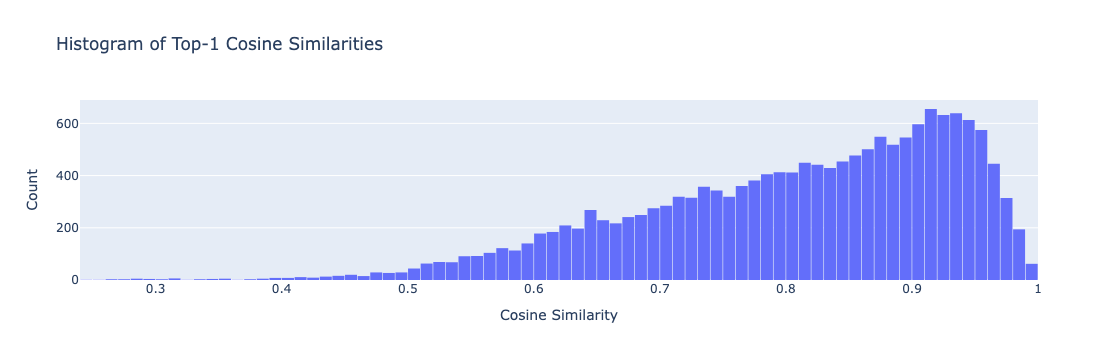

In [102]:
import plotly.graph_objects as go

top_k_values, _ = find_top_k_closest_features(sae_16k, sae_65k, k=1)
top1_scores = top_k_values.squeeze()

fig = go.Figure(data=[go.Histogram(x=top1_scores.cpu().numpy())])

fig.update_layout(
    title="Histogram of Top-1 Cosine Similarities",
    xaxis_title="Cosine Similarity",
    yaxis_title="Count",
    bargap=0.05
)

fig.show()

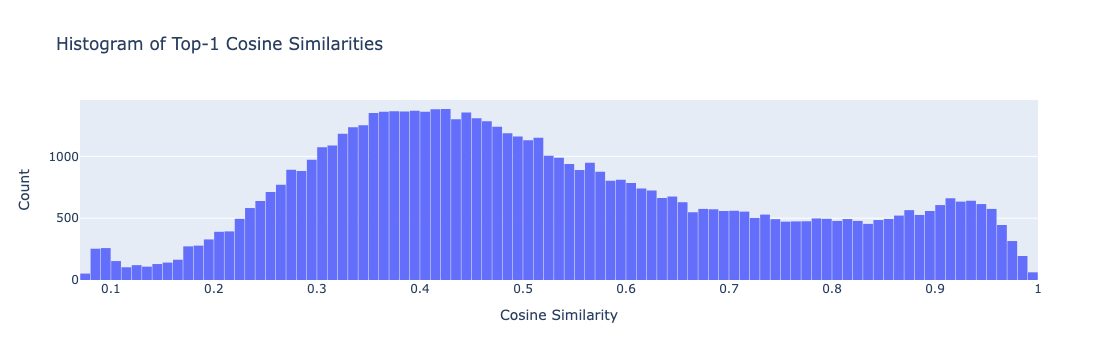

In [129]:
import plotly.graph_objects as go

top_k_values, _ = find_top_k_closest_features(sae_65k, sae_16k, k=1)
top1_scores = top_k_values.squeeze()

fig = go.Figure(data=[go.Histogram(x=top1_scores.cpu().numpy())])

fig.update_layout(
    title="Histogram of Top-1 Cosine Similarities",
    xaxis_title="Cosine Similarity",
    yaxis_title="Count",
    bargap=0.05
)

fig.show()

In [ ]:
prepare_and_steer(f"layer_20/width_65k/average_l0_61", 54077 )

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  1%|          | 1/100 [00:02<04:45,  2.89s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  2%|▏         | 2/100 [00:04<03:44,  2.29s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  3%|▎         | 3/100 [00:06<03:24,  2.10s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  4%|▍         | 4/100 [00:08<03:12,  2.00s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  5%|▌         | 5/100 [00:10<03:05,  1.96s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  6%|▌         | 6/100 [00:12<03:00,  1.92s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  7%|▋         | 7/100 [00:14<02:57,  1.90s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  8%|▊         | 8/100 [00:15<02:54,  1.89s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


  9%|▉         | 9/100 [00:17<02:51,  1.89s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


 10%|█         | 10/100 [00:19<02:49,  1.88s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


 11%|█         | 11/100 [00:21<02:47,  1.88s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


 12%|█▏        | 12/100 [00:23<02:44,  1.87s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


 13%|█▎        | 13/100 [00:25<02:42,  1.87s/it]

blocks.20.hook_resid_post
torch.Size([8, 1024, 65536])


 14%|█▍        | 14/100 [00:27<02:40,  1.87s/it]

In [134]:
def find_least_represented_features(sae1, sae2, k=10):
    # Get the top 1 closest feature for each feature in sae2
    top_values, _ = find_top_k_closest_features(sae1, sae2, k=1)
    
    # Flatten the top_values tensor
    max_similarities = top_values.squeeze()
    
    # Find the k features with the lowest maximum similarities
    bottom_k_values, bottom_k_indices = torch.topk(max_similarities, k=k, largest=False)
    
    return bottom_k_indices, bottom_k_values

In [ ]:
bottom_k_indices, bottom_k_values = find_least_represented_features(sae_65k, sae_16k, k=65535)

In [151]:
for i1, i2 in [(i1.item(), i2.item()) for (i1, i2) in zip(bottom_k_indices.squeeze(), list(bottom_k_values.squeeze()))]:
    print(i1, i2)

49603 0.07261680066585541
54265 0.0726185142993927
38613 0.07321533560752869
24777 0.07410158962011337
58560 0.07469267398118973
56229 0.07491513341665268
33983 0.07502596080303192
3655 0.0753588005900383
43043 0.07537271082401276
52070 0.07543838769197464
16455 0.07589388638734818
10324 0.07602103799581528
1543 0.0765160545706749
14747 0.07658495754003525
50618 0.07667361199855804
2497 0.07675006240606308
30219 0.07707659900188446
47463 0.07715427875518799
14053 0.07761885225772858
64275 0.07765714824199677
24742 0.07768502086400986
41736 0.07776622474193573
47733 0.07787363976240158
50944 0.07796534895896912
43555 0.0782691165804863
18376 0.0784246176481247
21459 0.07851969450712204
40105 0.0785689726471901
46549 0.07867635786533356
31867 0.07871785014867783
2217 0.07878781110048294
45144 0.07901013642549515
37976 0.07904048264026642
39339 0.07904307544231415
267 0.07921797037124634
39373 0.07923082262277603
32825 0.07927156239748001
58687 0.07931378483772278
13340 0.0793437436223030